In [2]:
#### Scraping historical prices of a product that on hepsiburada.com using Web-Archive API 

#necessary libraries

import requests
import re

import bs4 as bs
import urllib.request #In order to request

import numpy as np
import pandas as pd
import matplotlib as plt

In [3]:
#FIRST GET HISTORICAL LINKS OF PRODUCT USING WEB ARCHIVE API (CDX)
def historical_prices_of_product(product_url):

    # using web_archive cdx api
    api_answer = requests.get("http://web.archive.org/cdx/search/cdx?url={}".format(product_url))
    # take all results that contains date
    raw_api_answer_text = api_answer.text

    #scrape dates to use in webarchive url
    regex_to_find_dates = re.findall(r"\d{14}",raw_api_answer_text)

    product_links = []

    for date in regex_to_find_dates:
        # get web archive link structure
        archive_link = "https://web.archive.org/web/{}/{}".format(date,product_url)
        product_links.append(archive_link)
    
    return product_links,regex_to_find_dates


# TAKING PRICE FROM HEPSIBURADA.COM using beautiful soup
def hepsiburada_get_price(url):
    sauce = urllib.request.urlopen(url).read() #Returns the source code of the given URL
    soup = bs.BeautifulSoup(sauce,'lxml')  #To make beautifulsoup object,the parser used is lxml
    try:
        priceBeforePointArray = soup.find_all("span",{"data-bind":"markupText:'currentPriceBeforePoint'"})
        priceBeforePoint = priceBeforePointArray[0].text
        priceAfterArray = soup.find_all("span",{"data-bind":"markupText:'currentPriceAfterPoint'"})
        priceAfterPoint= priceAfterArray[0].text
    except:
        return "0"
    
    return priceBeforePoint+","+priceAfterPoint+" TL"

In [4]:
#product url ##enter product url (hepsiburada.com)
product_url = "https://www.hepsiburada.com/apple-iphone-5s-16-gb-apple-turkiye-garantili-pm-telcepiph5s6gbgo"

#product link and date using historical_prices_of_product function
product_historical_links, dates= historical_prices_of_product(product_url)

In [5]:
result_date_and_price = []

#loop to get date and price of product using hepsiburada_get_price function
for date_index,link in enumerate(product_historical_links):
    result_date_and_price.append([dates[date_index],hepsiburada_get_price(link)])

In [6]:
#raw format of date and price
result_date_and_price[:5]

[['20160427182143', '1.299,00 TL'],
 ['20160429083816', '1.299,00 TL'],
 ['20160503073758', '1.299,00 TL'],
 ['20160505023533', '1.299,00 TL'],
 ['20160517024221', '1.299,00 TL']]

In [21]:
#Convert result into beautiful DataFrame
result_array = np.array(result_date_and_price)
date = result_array[:,0]
price = result_array[:,1]
df = pd.DataFrame(data=[date,price])
df = df.T
df.columns = ["Date","Price"]

# Extract "0" prices values (when product no longer available - price is taken as "0")
df.loc[df['Price'] == '0'] = np.nan 
df = df.dropna()


# Date and Price columns are dirty, to clean and tidy them:
df['Date'] = df['Date'].apply(lambda x: x[:8])
df['Date'] = df['Date'].apply(lambda x: x[:4] + "/" + x[4:6] + "/" + x[6:8])
df['Date'] = pd.to_datetime(df['Date'], format="%Y/%m/%d")

df['Price'] = df['Price'].apply(lambda x: x[:-3])
df['Price'] = df['Price'].apply(lambda x: re.sub("\.","",x))
df['Price'] = df['Price'].apply(lambda x: re.sub("\,",".",x))
df['Price'] = df['Price'].astype('float64')

df.head()

,Date,Price
0,2016-04-27,1299.0
1,2016-04-29,1299.0
2,2016-05-03,1299.0
3,2016-05-05,1299.0
4,2016-05-17,1299.0


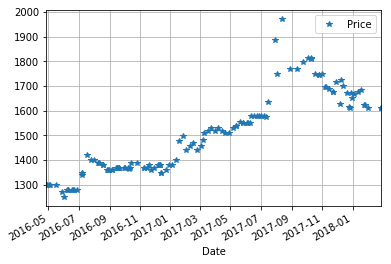

In [25]:
#127 historical prices of Iphone 5s is collected.

df.plot('Date','Price',style='*',grid=True)